# Introduction to Keras

## 1. Classifying bank complaints

### 1.1 Loading the data

#### 1.1.1 Look at the data

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


In [110]:
df = df.sample(10000)

In [111]:
df.index = range(10000)

In [112]:
product = df["Product"]

There are 7 types of complaints

In [113]:
product.value_counts()

Student loan                   1886
Consumer Loan                  1632
Credit card                    1565
Mortgage                       1412
Bank account or service        1381
Credit reporting               1133
Checking or savings account     991
Name: Product, dtype: int64

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Product                         10000 non-null object
Consumer complaint narrative    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [115]:
complaints = df["Consumer complaint narrative"]

### 1.1.2 One-hot encoding of the complaints

Only keep 2,000 most common words and use one-hot encoding

In [117]:
tokenizer = Tokenizer(num_words=2000)

In [118]:
tokenizer.fit_on_texts(complaints)

In [119]:
sequences = tokenizer.texts_to_sequences(complaints)

In [120]:
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 21489 unique tokens.


In [121]:
word_index.items()

dict_items([('xxxx', 1), ('the', 2), ('i', 3), ('to', 4), ('and', 5), ('my', 6), ('a', 7), ('that', 8), ('of', 9), ('was', 10), ('in', 11), ('they', 12), ('on', 13), ('for', 14), ('have', 15), ('not', 16), ('me', 17), ('this', 18), ('is', 19), ('with', 20), ('xx', 21), ('it', 22), ('account', 23), ('00', 24), ('from', 25), ('credit', 26), ('had', 27), ('as', 28), ('be', 29), ('loan', 30), ('bank', 31), ('payment', 32), ('would', 33), ('at', 34), ('them', 35), ('been', 36), ('an', 37), ('by', 38), ('but', 39), ('no', 40), ('we', 41), ('or', 42), ('are', 43), ('told', 44), ('did', 45), ('when', 46), ('do', 47), ('has', 48), ('were', 49), ("n't", 50), ('which', 51), ('all', 52), ('am', 53), ('payments', 54), ('so', 55), ('time', 56), ('their', 57), ('card', 58), ('received', 59), ('called', 60), ('after', 61), ('you', 62), ('pay', 63), ('because', 64), ('if', 65), ('out', 66), ('any', 67), ('can', 68), ('information', 69), ("''", 70), ("'s", 71), ('get', 72), ('there', 73), ('will', 74), 

In [123]:
np.shape(one_hot_results)

(10000, 2000)

Decode the review again, can be done as follows:

word_index stores the mapping from the label number to the actual word.

In [124]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_index.get(i) for i in sequences[19]])

In [125]:
decoded_review

"i have been working since last to submit pslf paperwork and get an updated count of current qualifying payments i have had to paperwork several times and have made several phone calls to the servicer multiple times throughout the xxxx then again in xxxx xxxx xxxx and xxxx of this year each time i am provided with different information either my paperwork is being reviewed or they are going to place it under review i am assured that i will receive some kind of documentation either online in my account or via mail within a certain time d 60 days sometimes 90 days and to please wait i still do not have the information i have been asking for do not know how many qualifying payments are being towards pslf and have not been given any information on what i can do to move forward currently my account o 17 pslf payments even though this number should be to 50 i can not get any explanation for what is being what is not being and why during my last phone call in xxxx i was total that a payment t

In [126]:
complaints[19]

'I have been working since last summer to submit PSLF paperwork and get an updated count of current qualifying payments. I have had to resubmit paperwork several times, and have made several phone calls to the servicer ( multiple times throughout the summer   XXXX  , then again in  XXXX ,  XXXX ,  XXXX , and  XXXX  of this year. ) Each time I am provided with different information. Either my paperwork is being reviewed, or they are going to place it under review. I am assured that I will receive some kind of documentation ( either online in my account or via mail ) within a certain time perio d ( som etimes 60 days, sometimes 90 days ) and to please wait. I still do not have the information I have been asking for, do not know how many qualifying payments are being counted towards PSLF and have not been given any information on what I can do to move forward. Currently, my account reflects o nly 17 qual ifying PSLF payments, even though this number should be closer  to 50. I can  not get

You can see that some words dropped, but hopefully we caught the ones that have the useful distincive characteristics!

### 1.1.3 convert the products to numerical categories

In [127]:
le = preprocessing.LabelEncoder()

In [128]:
le.fit(product)

LabelEncoder()

In [129]:
list(le.classes_)

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Mortgage',
 'Student loan']

In [130]:
product_cat = le.transform(product) 

In [131]:
list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4]))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Bank account or service',
 'Checking or savings account',
 'Credit card',
 'Credit card',
 'Bank account or service',
 'Student loan',
 'Credit reporting']

In [132]:
product_cat

array([5, 6, 3, ..., 1, 3, 4])

In [133]:
product_onehot = to_categorical(product_cat)

In [134]:
np.shape(product_onehot)

(10000, 7)

### 1.1.4 Train - test split

In [136]:
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

Create a test and a training set

In [137]:
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

In [138]:
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

In [139]:
print(np.shape(label_test))
print(np.shape(label_train))
print(np.shape(test))
print(np.shape(train))

(1500, 7)
(8500, 7)
(1500, 2000)
(8500, 2000)


# 1.2 Building the network

The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you’ll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: `Dense(16, activation='relu')`.

In this examples, use 3 hidden layers with 32 units in the first layer, 16 in the second, and 16 in the last hidden layer again, and a `relu` activation function. Because we are dealing with a binary classification problem (good versus bad review), use a sigmoid function in order to output a probability.

In [149]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

### 1.3 Validating the approach

create a validation set with 5,000 samples from the original train data set

In [141]:
val = train[:1000]
train_final = train[1000:]
label_val = label_train[:1000]
label_train_final = label_train[1000:]

### 1.4 Compiling the model and look at the results

In [142]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 20 epochs in mini-batches of 512 samples.

In [143]:
history = model.fit(train_final,
                    label_train_final,
                    epochs=20,
                    batch_size=200,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/20
7500/7500 [==============================] - 1s 121us/step - loss: 1.4447 - acc: 0.5219 - val_loss: 1.0838 - val_acc: 0.6640
Epoch 2/20
7500/7500 [==============================] - 0s 59us/step - loss: 0.8495 - acc: 0.7572 - val_loss: 0.7922 - val_acc: 0.7420
Epoch 3/20
7500/7500 [==============================] - 0s 57us/step - loss: 0.6097 - acc: 0.8164 - val_loss: 0.6933 - val_acc: 0.7560
Epoch 4/20
7500/7500 [==============================] - 0s 54us/step - loss: 0.4710 - acc: 0.8595 - val_loss: 0.6646 - val_acc: 0.7640
Epoch 5/20
7500/7500 [==============================] - 0s 55us/step - loss: 0.3841 - acc: 0.8828 - val_loss: 0.6388 - val_acc: 0.7700
Epoch 6/20
7500/7500 [==============================] - 0s 56us/step - loss: 0.3182 - acc: 0.9044 - val_loss: 0.6515 - val_acc: 0.7790
Epoch 7/20
7500/7500 [==============================] - 0s 56us/step - loss: 0.2699 - acc: 0.9209 - val_loss: 0.6626 - val_acc: 0.7730
Epoch 

The dictionary `history` contains four entries: one per metric that was being monitored during training and during validation.

In [144]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

### 1.5 Plot the results

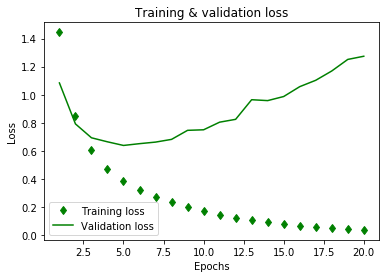

In [163]:
plt.clf()

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'gd', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

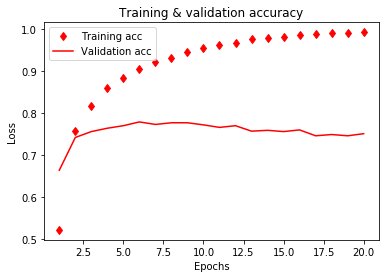

In [164]:
plt.clf()

acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'rd', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. What you’re seeing is overfitting: after the  third epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

### 1.6  retrain from scratch with fewer epochs

In [151]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #3 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=5,
                    batch_size=200,
                    validation_data=(val, label_val))
results = model.evaluate(test, label_test)

Train on 7500 samples, validate on 1000 samples
Epoch 1/5
7500/7500 [==============================] - 1s 108us/step - loss: 1.4974 - acc: 0.5085 - val_loss: 1.1153 - val_acc: 0.6760
Epoch 2/5
7500/7500 [==============================] - 0s 66us/step - loss: 0.8696 - acc: 0.7568 - val_loss: 0.7909 - val_acc: 0.7650
Epoch 3/5
7500/7500 [==============================] - 0s 65us/step - loss: 0.6070 - acc: 0.8232 - val_loss: 0.7059 - val_acc: 0.7660
Epoch 4/5
7500/7500 [==============================] - 0s 55us/step - loss: 0.4608 - acc: 0.8608 - val_loss: 0.6558 - val_acc: 0.7860
Epoch 5/5
1500/1500 [==============================] - 0s 120us/step


Now, you can use the test set to make label predictions

In [155]:
model.predict(test)

array([[9.69503224e-01, 9.14363470e-03, 6.86577769e-05, ...,
        4.94806445e-05, 6.88952161e-04, 4.27879480e-04],
       [3.27318558e-03, 1.76739894e-04, 2.06370116e-03, ...,
        9.90884125e-01, 2.09492352e-03, 5.19673515e-04],
       [9.82209444e-01, 1.53416665e-02, 3.39370927e-05, ...,
        1.96822530e-05, 8.72913006e-05, 2.26852226e-05],
       ...,
       [2.70833807e-05, 3.13575083e-06, 1.10132962e-04, ...,
        1.03743114e-04, 9.09768860e-05, 9.99662280e-01],
       [8.92237451e-10, 1.26295463e-09, 6.73468264e-07, ...,
        2.51507459e-09, 3.22322308e-07, 9.99999046e-01],
       [2.22235289e-03, 1.78149494e-03, 4.65049930e-02, ...,
        8.66547167e-01, 4.31820052e-03, 9.99510195e-03]], dtype=float32)

In [156]:
results

[0.6629239962100982, 0.765333333492279]

# SOURCES

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database